In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import Adam

from utils import CustomResNet, fashionmnist_dataloader, train_cutmix, val, criterion

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='cuda')

In [ ]:
train_loader, val_loader, test_loader= fashionmnist_dataloader(batch_size=50, basic_aug=False)

100%|██████████| 26421880/26421880 [00:01<00:00, 14860355.32it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 269386.94it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5042206.36it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 24564592.71it/s]
/opt/conda/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 26421880/26421880 [00:01<00:00, 14844606.04it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 270247.89it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5078328.50it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10652332.01it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
num_classes = 10
num_epochs = 10
patience = 3
alpha=2.5
criterion=criterion()

possible_layer_configurations = [
    [0],          # Deform none
    [1],          # Deform layer 1
    [2],          # Deform layer 2
    [3],          # Deform layer 3
    [1, 2],       # Deform layers 1 and 2
    [1, 3],       # Deform layers 1 and 3
    [2, 3],       # Deform layers 2 and 3
    [1, 2, 3]     # Deform all layers 1, 2, and 3
]

all_model_results = []

for layers_to_deform in possible_layer_configurations:

    print(f"Training with deformable layers: {layers_to_deform}")
    model = CustomResNet(num_classes, layers_to_deform).to(device)
    optimizer = Adam(model.parameters(), lr=3e-4)
    #print(model)

    validation_accuracies = []
    best_val_acc = float('-inf')
    current_patience = 0

    for epoch in range(1, num_epochs + 1):
        train_cutmix(model, criterion, train_loader, optimizer, epoch, alpha, device)
        val_acc = val(model, criterion, val_loader, device)
        validation_accuracies.append(val_acc[0])
        if val_acc[0] > best_val_acc:
            best_val_acc = val_acc[0]
            current_patience = 0
        else:
            current_patience += 1

        if current_patience >= patience:
            print(f'Early stopping: No improvement for {patience} epochs.')
            break
    # Store the results for this model configuration
    model_results = {
        "layers_to_deform": layers_to_deform,
        "validation_accuracies": validation_accuracies
    }

    # Append the results to the list of all model results
    all_model_results.append(model_results)

Training with deformable layers: [0]


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 192MB/s]


Train Epoch: 1	Average Loss: 0.769046	Accuracy: 75.84%
Val Loss: 0.3529, Val Accuracy: 87.15%
Train Epoch: 2	Average Loss: 0.465602	Accuracy: 83.64%
Val Loss: 0.2792, Val Accuracy: 89.65%
Train Epoch: 3	Average Loss: 0.405827	Accuracy: 85.79%
Val Loss: 0.2607, Val Accuracy: 90.47%
Train Epoch: 4	Average Loss: 0.370789	Accuracy: 86.77%
Val Loss: 0.2213, Val Accuracy: 91.98%
Train Epoch: 5	Average Loss: 0.345360	Accuracy: 87.93%
Val Loss: 0.2212, Val Accuracy: 92.12%
Train Epoch: 6	Average Loss: 0.327903	Accuracy: 88.33%
Val Loss: 0.2175, Val Accuracy: 92.41%
Train Epoch: 7	Average Loss: 0.313068	Accuracy: 89.00%
Val Loss: 0.1949, Val Accuracy: 93.21%
Train Epoch: 8	Average Loss: 0.294950	Accuracy: 89.74%
Val Loss: 0.2095, Val Accuracy: 92.57%
Train Epoch: 9	Average Loss: 0.280002	Accuracy: 90.03%
Val Loss: 0.2075, Val Accuracy: 92.73%
Train Epoch: 10	Average Loss: 0.272550	Accuracy: 90.33%
Val Loss: 0.1911, Val Accuracy: 93.53%
Training with deformable layers: [1]
Train Epoch: 1	Average

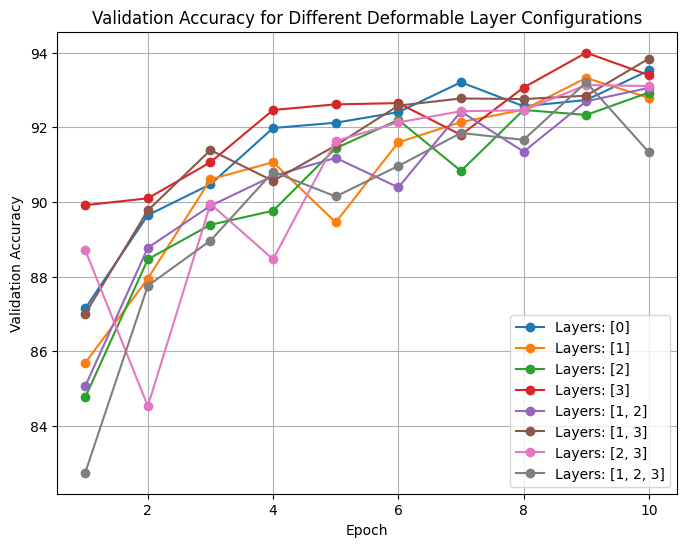

In [ ]:
# Create a single figure to hold the plot
plt.figure(figsize=(8, 6))

# Loop through the results for different model configurations
for result in all_model_results:
    layers_to_deform = result["layers_to_deform"]
    validation_accuracies = result["validation_accuracies"]

    # Plot the validation accuracies for this model configuration
    plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, marker='o', label=f'Layers: {layers_to_deform}')

# Customize the plot
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy for Different Deformable Layer Configurations')
plt.legend(loc='best')
plt.grid()

# Show the single graph with all the data
plt.show()
